# spikeinterface clustering

The clustering step remains the central step of the spike sorting.
Historically this step was separted into two distinct parts: feature reduction and clustering.
In spikeinterface, we decided to regroup this two steps in the same module.
This allows one to compute feature reduction on-the-fly and avoid long computations and storage of 
large features.

The clustering step takes the recording and detected (and optionally selected) peaks as input and returns 
a label for every peak.

At the moment, the implemenation is quite experimental.
These methods have been implemented:
  * "position_clustering": use HDBSCAN on peak locations.
  * "sliding_hdbscan": clustering approach from tridesclous, with sliding spatial windows. PCA and HDBSCAN are run 
    on local/sparse waveforms.
  * "position_pca_clustering": this method tries to use peak locations for a first clustering step and then perform 
  further splits using PCA + HDBSCAN

Different methods may need different inputs (for instance some of them require need peak locations and some do not).



For this we will use a simulated with **mearec** dataset on 32 channel neuronexus like probe.


Here we will also use the `select_peak()` function to sub sample a smaller number of peak




In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import time

import numpy as np
import matplotlib.pyplot as plt


import spikeinterface.full as si



/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/datalad/cmd.py:375: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  new_loop = True
/home/samuel.garcia/Documents/SpikeInterface/spikeinterface/spikeinterface/core/datasets.py:12: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  HAVE_DATALAD = False


In [18]:
base_folder = Path('/mnt/data/sam/DataSpikeSorting/mearec_template_matching')
mearec_file = base_folder / 'recordings_collision_15cells_Neuronexus-32_1800s.h5'
rec_folder = base_folder /'Preprocessed_recording_15cells_Neuronexus-32_1800s'
peak_folder = base_folder / 'Peak_recording_15cells_Neuronexus'

clustering_path = base_folder / 'Clustering_recording_15cells_Neuronexus'

peak_folder.mkdir(exist_ok=True)


In [5]:
# global kwargs for parallel computing
job_kwargs = dict(
    n_jobs=40,
    chunk_duration='1s',
    progress_bar=True,
)

### Preprocess

In [6]:
# load already cache or compute
if rec_folder.exists():
    rec_preprocessed = si.load_extractor(rec_folder)
else:
    recording, gt_sorting = si.read_mearec(mearec_file)
    recording = si.bandpass_filter(recording, dtype='float32')
    recording = si.common_reference(recording)
    rec_preprocessed = recording.save(folder=rec_folder, n_jobs=20, chunk_size=30000, progress_bar=True)

### estimate noise

Text(0.5, 1.0, 'noise across channel')

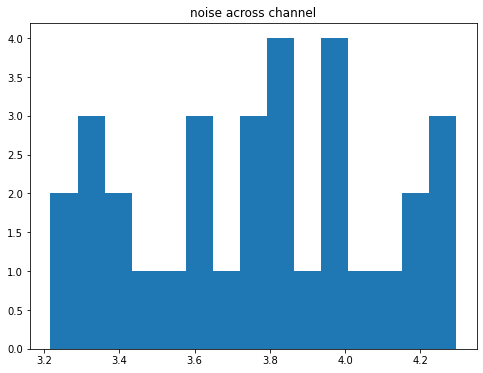

In [7]:
noise_levels = si.get_noise_levels(rec_preprocessed, return_scaled=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(noise_levels, bins=15)
ax.set_title('noise across channel')

## detect peaks

In [8]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

In [9]:
if not (peak_folder / 'peaks.npy').exists():
    peaks = detect_peaks(
        rec_preprocessed,
        method='locally_exclusive',
        local_radius_um=100,
        peak_sign='neg',
        detect_threshold=5,
        n_shifts=10,
        noise_levels=noise_levels,
        **job_kwargs,
    )
    np.save(peak_folder / 'peaks.npy', peaks)
peaks = np.load(peak_folder / 'peaks.npy')
print(peaks.shape)


(271519,)


## select peaks

In [10]:
from spikeinterface.sortingcomponents.peak_selection import select_peaks


In [11]:
if not (peak_folder / 'some_peaks.npy').exists():
    some_peaks = select_peaks(peaks, method='uniform', select_per_channel=True, n_peaks=500, seed=None)
    np.save(peak_folder / 'some_peaks.npy', some_peaks)
some_peaks = np.load(peak_folder / 'some_peaks.npy')
print('some_peaks.size', some_peaks.size)

some_peaks.size 13424


## localize peaks (on sub selection)

In [12]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

In [14]:
some_peak_locations = localize_peaks(rec_preprocessed, some_peaks,
        method='monopolar_triangulation',
        method_kwargs={'local_radius_um': 100., 'max_distance_um': 1000., 'optimizer': 'minimize_with_log_penality'},
        # method_kwargs={'local_radius_um': 100., 'max_distance_um': 1000., 'optimizer': 'least_square'},
        **job_kwargs)
np.save(peak_folder / 'some_peak_locations.npy', some_peak_locations)

localize peaks: 100%|██████████| 1800/1800 [00:03<00:00, 513.78it/s]


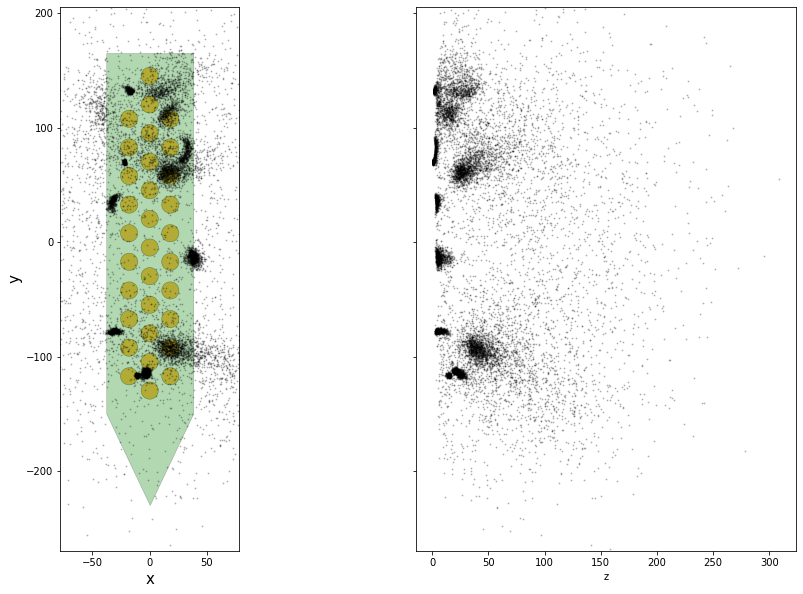

In [15]:
some_peak_locations = np.load(peak_folder / f'some_peak_locations.npy')

probe = rec_preprocessed.get_probe()

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))
ax = axs[0]
si.plot_probe_map(rec_preprocessed, ax=ax)
ax.scatter(some_peak_locations['x'], some_peak_locations['y'], color='k', s=1, alpha=0.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
if 'z' in some_peak_locations.dtype.fields:
    ax = axs[1]
    ax.scatter(some_peak_locations['z'], some_peak_locations['y'], color='k', s=1, alpha=0.2)
    ax.set_xlabel('z')
# ax.set_ylim(1500, 2500)

## clustering (on sub selection)

In [19]:
from spikeinterface.sortingcomponents.clustering import find_cluster_from_peaks

In [43]:


method_kwargs = dict(
    peak_locations=some_peak_locations,
    hdbscan_params_spatial = {"min_cluster_size" : 20,  "allow_single_cluster" : True, 'metric' : 'l2'},
    probability_thr = 0,
    apply_norm=True,
    #~ debug=True,
    debug=False,
    tmp_folder=clustering_path,
    n_components_by_channel=4,
    n_components=4,
    job_kwargs = {"n_jobs" : 2, "chunk_size" : 30000, "progress_bar" : True},
    waveform_mode="shared_memory",
    #~ waveform_mode="memmap",
)

t0 = time.perf_counter()
possible_labels, peak_labels = find_cluster_from_peaks(rec_preprocessed, some_peaks, 
        method='position_pca_clustering', method_kwargs=method_kwargs)
t1 = time.perf_counter()
print('position_pca_clustering', t1 -t0)


extract waveforms shared_memory: 100%|██████████| 1800/1800 [00:00<00:00, 5033.09it/s]


position_pca_clustering 12.23708628397435


In [44]:
print(possible_labels)

[ 3  4  6 10 11 14 16 18 19 20 22 28 29 32 33]


In [45]:
import distinctipy
def plot_cluster_on_probe(rec, possible_labels, peak_labels):
    possible_colors = distinctipy.get_colors(possible_labels.size)

    colors = np.zeros((peak_labels.size, 3))
    for i, k in enumerate(possible_labels):
        mask = peak_labels == k
        colors[mask, :] = possible_colors[i]
    colors[mask, :] = possible_colors[i]
    

    fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))
    ax = axs[0]
    si.plot_probe_map(rec, ax=ax)
    ax.scatter(some_peak_locations['x'], some_peak_locations['y'], s=1, c=colors, alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if 'z' in some_peak_locations.dtype.fields:
        ax = axs[1]
        ax.scatter(some_peak_locations['z'], some_peak_locations['y'], s=1, c=colors, alpha=0.5)
        ax.set_xlabel('z')



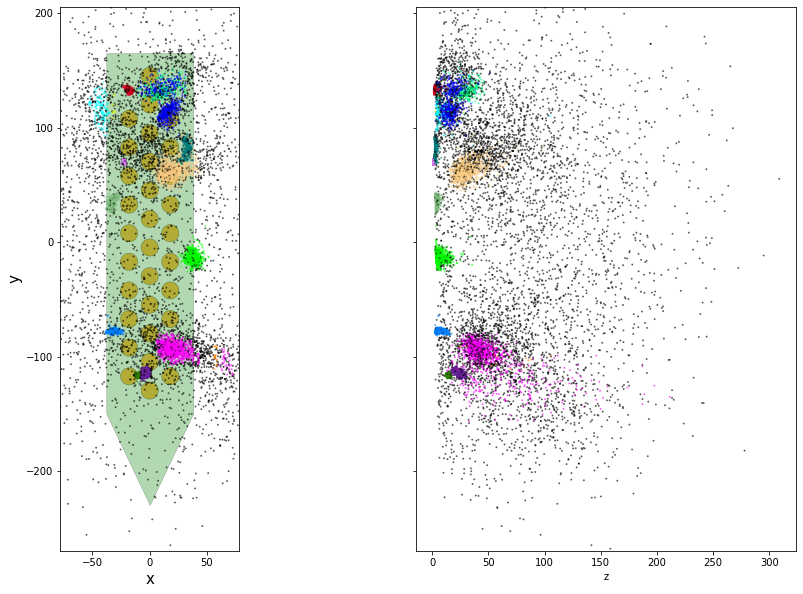

In [46]:
plot_cluster_on_probe(rec_preprocessed, possible_labels, peak_labels)

## lets try another method

In [47]:


method_kwargs = dict(
)

t0 = time.perf_counter()
possible_labels, peak_labels = find_cluster_from_peaks(rec_preprocessed, some_peaks, 
        method='sliding_hdbscan', method_kwargs=method_kwargs)
t1 = time.perf_counter()
print('position_pca_clustering', t1 -t0)

position_pca_clustering 19.997920085676014


In [48]:
print(possible_labels)

[ 1  2  3  4  5  6  7  8  9 10 11 16 20]


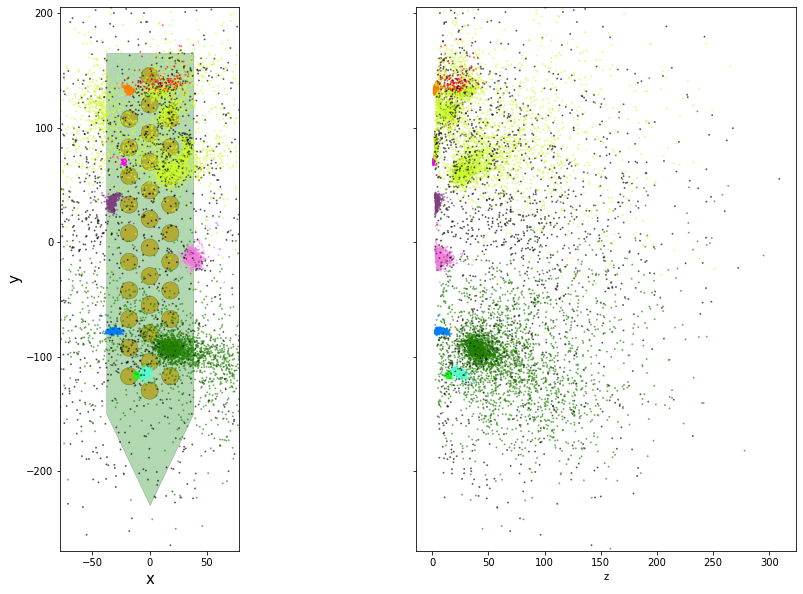

In [49]:
plot_cluster_on_probe(rec_preprocessed, possible_labels, peak_labels)